# Neural IBM1

NLP2 2016/2017 Project 3

In [1]:
# first run a few imports:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from pprint import pprint
import pickle

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt


### Let's first load some data

In [2]:
# the paths to our training and validation data, English side
train_e_path = '../../data/training/hansards.36.2.e.gz'
train_f_path = '../../data/training/hansards.36.2.f.gz'
dev_e_path = '../../data/validation/dev.e.gz'
dev_f_path = '../../data/validation/dev.f.gz'
dev_wa = '../../data/validation/dev.wa.nonullalign'

In [3]:
# check utils.py if you want to see how smart_reader and bitext_reader work in detail
from utils import smart_reader, bitext_reader

    
def bitext_reader_demo(src_path, trg_path):
  """Demo of the bitext reader."""
 
  # create a reader
  src_reader = smart_reader(src_path)
  trg_reader = smart_reader(trg_path)
  bitext = bitext_reader(src_reader, trg_reader)

  # to see that it really works, try this:
  print(next(bitext))
  print(next(bitext))
  print(next(bitext))
  print(next(bitext))  


bitext_reader_demo(train_e_path, train_f_path)

(['36', 'th', 'Parliament', ',', '2', 'nd', 'Session'], ['36', 'e', 'Législature', ',', '2', 'ième', 'Session'])
(['edited', 'HANSARD', '*', 'NUMBER', '1'], ['hansard', 'RÉVISÉ', '*', 'NUMÉRO', '1'])
(['contents'], ['table', 'DES', 'MATIÈRES'])
(['Tuesday', ',', 'October', '12', ',', '1999'], ['le', 'mardi', '12', 'octobre', '1999'])


In [4]:
# To see how many sentences are left if you filter by length, you can do this:

def demo_number_filtered_sentence_pairs(src_path, trg_path):
  src_reader = smart_reader(src_path)
  trg_reader = smart_reader(trg_path)
  max_length = 30
  bitext = bitext_reader(src_reader, trg_reader, max_length=max_length)   
  num_sentences = sum([1 for _ in bitext])
  print("There are {} sentences with max_length = {}".format(num_sentences, max_length))
  
  
demo_number_filtered_sentence_pairs(train_e_path, train_f_path)

There are 178928 sentences with max_length = 30


### Now, let's create a vocabulary!

We first define a class `Vocabulary` that helps us convert tokens (words) into numbers. This is useful later, because then we can e.g. index a word embedding table using the ID of a word.

In [5]:
# check vocabulary.py to see how the Vocabulary class is defined
from vocabulary import OrderedCounter, Vocabulary 

Now let's try out our Vocabulary class:

In [6]:
def vocabulary_demo():

  # We used up a few lines in the previous example, so we set up
  # our data generator again.
  corpus = smart_reader(train_e_path)    

  # Let's create a vocabulary given our (tokenized) corpus
  vocabulary = Vocabulary(corpus=corpus)
  print("Original vocabulary size: {}".format(len(vocabulary)))

  # Now we only keep the highest-frequency words
  vocabulary_size=1000
  vocabulary.trim(vocabulary_size)
  print("Trimmed vocabulary size: {}".format(len(vocabulary)))

  # Now we can get word indexes using v.get_word_id():
  for t in ["<PAD>", "<UNK>", "the"]:
    print("The index of \"{}\" is: {}".format(t, vocabulary.get_token_id(t)))

  # And the inverse too, using v.i2t:
  for i in range(10):
    print("The token with index {} is: {}".format(i, vocabulary.get_token(i)))

  # Now let's try to get a word ID for a word not in the vocabulary
  # we should get 1 (so, <UNK>)
  for t in ["!@!_not_in_vocab_!@!"]:
    print("The index of \"{}\" is: {}".format(t, vocabulary.get_token_id(t)))
    
    
vocabulary_demo()

Original vocabulary size: 36640
Trimmed vocabulary size: 1005
The index of "<PAD>" is: 0
The index of "<UNK>" is: 1
The index of "the" is: 5
The token with index 0 is: <PAD>
The token with index 1 is: <UNK>
The token with index 2 is: <S>
The token with index 3 is: </S>
The token with index 4 is: <NULL>
The token with index 5 is: the
The token with index 6 is: .
The token with index 7 is: ,
The token with index 8 is: of
The token with index 9 is: to
The index of "!@!_not_in_vocab_!@!" is: 1


Now let's create the vocabularies that we use further on.

In [7]:
# Using only 1000 words will result in many UNKs, but
# it will make training a lot faster. 
# If you have a fast computer, a GPU, or a lot of time,
# try with 10000 instead.
max_tokens=1000

corpus_e = smart_reader(train_e_path)    
vocabulary_e = Vocabulary(corpus=corpus_e, max_tokens=max_tokens)
pickle.dump(vocabulary_e, open("vocabulary_e.pkl", mode="wb"))
print("English vocabulary size: {}".format(len(vocabulary_e)))

corpus_f = smart_reader(train_f_path)    
vocabulary_f = Vocabulary(corpus=corpus_f, max_tokens=max_tokens)
pickle.dump(vocabulary_f, open("vocabulary_f.pkl", mode="wb"))
print("French vocabulary size: {}".format(len(vocabulary_f)))
print()


def sample_words(vocabulary, n=5):
  """Print a few words from the vocabulary."""
  for _ in range(n):
    token_id = np.random.randint(0, len(vocabulary) - 1)
    print(vocabulary.get_token(token_id))


print("A few English words:")
sample_words(vocabulary_e, n=5)
print()

print("A few French words:")
sample_words(vocabulary_f, n=5)

English vocabulary size: 1005
French vocabulary size: 1005

A few English words:
cuts
companies
March
any
development

A few French words:
assurer
existe
gestion
remercie
taux


### Mini-batching

With our vocabulary, we still need a method that converts a whole sentence to a sequence of IDs.
And, to speed up training, we would like to get a so-called mini-batch at a time: multiple of such sequences together. So our function takes a corpus iterator and a vocabulary, and returns a mini-batch of shape [Batch, Time], where the first dimension indexes the sentences in the batch, and the second the time steps in each sentence. 

In [8]:
from utils import iterate_minibatches, prepare_data

Let's try it out!

In [9]:
src_reader = smart_reader(train_e_path)
trg_reader = smart_reader(train_f_path)
bitext = bitext_reader(src_reader, trg_reader)


for batch_id, batch in enumerate(iterate_minibatches(bitext, batch_size=4)):

  print("This is the batch of data that we will train on, as tokens:")
  pprint(batch)
  print()

  x, y = prepare_data(batch, vocabulary_e, vocabulary_f)

  print("These are our inputs (i.e. words replaced by IDs):")
  print(x)
  print()
  
  print("These are the outputs (the foreign sentences):")
  print(y)
  print()

  if batch_id > 0:
    break  # stop after the first batch, this is just a demonstration


This is the batch of data that we will train on, as tokens:
[(['36', 'th', 'Parliament', ',', '2', 'nd', 'Session'],
  ['36', 'e', 'Législature', ',', '2', 'ième', 'Session']),
 (['edited', 'HANSARD', '*', 'NUMBER', '1'],
  ['hansard', 'RÉVISÉ', '*', 'NUMÉRO', '1']),
 (['contents'], ['table', 'DES', 'MATIÈRES']),
 (['Tuesday', ',', 'October', '12', ',', '1999'],
  ['le', 'mardi', '12', 'octobre', '1999'])]

These are our inputs (i.e. words replaced by IDs):
[[  4   1 745 325   7 262   1   1]
 [  4   1   1  67   1 238   0   0]
 [  4   1   0   0   0   0   0   0]
 [  4   1   7 813 882   7 297   0]]

These are the outputs (the foreign sentences):
[[  1   1   1   7 254   1   1]
 [  1   1  62   1 250   0   0]
 [  1 463   1   0   0   0   0]
 [  6   1   1 840 295   0   0]]

This is the batch of data that we will train on, as tokens:
[(['opening',
   'OF',
   'THE',
   'SECOND',
   'SESSION',
   'OF',
   'THE',
   '36',
   'TH',
   'PARLIAMENT'],
  ['ouverture',
   'DE',
   'LA',
   'DEUXIÈME',

Now, notice the following:

1. Every English sequence starts with a 4, the ID for < NULL \>.
2. The longest sequence in the batch contains no padding symbols. Any sequences shorter, however, will have padding zeros.

With our input pipeline in place, now let's create a model.

### Building our model

In [10]:
# check neuralibm1.py for the Model code
from neuralibm1_extension_2 import NeuralIBM1Model

### Training the model

Now that we have a model, we need to train it. To do so we define a Trainer class that takes our model as an argument and trains it, keeping track of some important information.



In [11]:
# check neuralibm1trainer.py for the Trainer code
from neuralibm1trainer import NeuralIBM1Trainer

Now we instantiate a model and start training.

Training with B=4 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 71.725174 accuracy 0.17 lr 0.001000
Iter   200 loss 75.422180 accuracy 0.20 lr 0.001000
Iter   300 loss 39.223152 accuracy 0.31 lr 0.001000
Iter   400 loss 59.004333 accuracy 0.20 lr 0.001000
Iter   500 loss 19.631357 accuracy 0.35 lr 0.001000
Iter   600 loss 62.217369 accuracy 0.04 lr 0.001000
Iter   700 loss 50.590588 accuracy 0.16 lr 0.001000
Iter   800 loss 101.716125 accuracy 0.15 lr 0.001000
Iter   900 loss 46.230385 accuracy 0.22 lr 0.001000
Iter  1000 loss 89.173500 accuracy 0.14 lr 0.001000
Iter  1100 loss 29.892262 accuracy 0.12 lr 0.001000
Iter  1200 loss 54.070114 accuracy 0.16 lr 0.001000
Iter  1300 loss 48.100067 accuracy 0.14 lr 0.001000
Iter  1400 loss 74.225395 accuracy 0.24 lr 0.001000
Iter  1500 loss 52.162270 accuracy 0.25 lr 0.001000
Iter  1600 loss 46.635967 accuracy 0.29 lr 0.001000
Iter  1700 loss 72.499451 accuracy 0.18 lr 0.

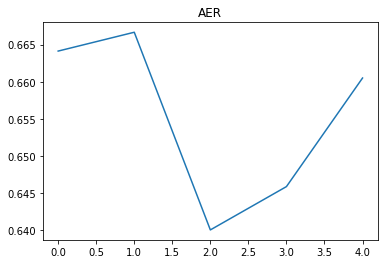

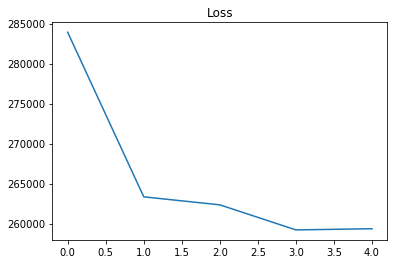

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:

  # some hyper-parameters
  # tweak them as you wish
#   batch_size=128  # on CPU, use something much smaller e.g. 1-16
  batch_size=4
  max_length=30
  lr = 0.001
  lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
  emb_dim = 64
  mlp_dim = 128
  
  # our model
  model = NeuralIBM1Model(
    x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
    batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)
  
  # our trainer
  trainer = NeuralIBM1Trainer(
    model, train_e_path, train_f_path, 
    dev_e_path, dev_f_path, dev_wa,
    num_epochs=5, batch_size=batch_size, 
    max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess)

  # now first TF needs to initialize all the variables
  print("Initializing variables..")
  sess.run(tf.global_variables_initializer())

  # now we can start training!
  print("Training started..")
  trainer.train()


In [ ]:
plot_AER = [0.766109785202864, 0.7267759562841529, 0.7706521739130434, 0.8188976377952756, 0.8419689119170984]
plot_Loss= [41346.684804975986, 12309.765393793583, 11828.69825476408, 11667.897045254707, 11614.337039470673]

plt.figure()
plt.title('AER')
plt.plot(plot_AER)

plt.figure()
plt.title('Loss')
plt.plot(plot_Loss)

Training with B=4 max_length=30 lr=0.001 lr_decay=0.0
Initializing variables..
Training started..
Shuffling training data
Iter   100 loss 64.204697 accuracy 0.04 lr 0.001000
Iter   200 loss 37.279198 accuracy 0.28 lr 0.001000
Iter   300 loss 97.141830 accuracy 0.27 lr 0.001000
Iter   400 loss 87.970047 accuracy 0.20 lr 0.001000
Iter   500 loss 71.438667 accuracy 0.14 lr 0.001000
Iter   600 loss 76.836639 accuracy 0.15 lr 0.001000
Iter   700 loss 27.023617 accuracy 0.09 lr 0.001000
Iter   800 loss 52.257576 accuracy 0.18 lr 0.001000
Iter   900 loss 52.869137 accuracy 0.23 lr 0.001000
Iter  1000 loss 34.065285 accuracy 0.28 lr 0.001000
Iter  1100 loss 87.051163 accuracy 0.20 lr 0.001000
Iter  1200 loss 65.965897 accuracy 0.13 lr 0.001000
Iter  1300 loss 51.882492 accuracy 0.30 lr 0.001000
Iter  1400 loss 57.963516 accuracy 0.23 lr 0.001000
Iter  1500 loss 83.767258 accuracy 0.18 lr 0.001000
Iter  1600 loss 28.003244 accuracy 0.33 lr 0.001000
Iter  1700 loss 56.264610 accuracy 0.16 lr 0.0

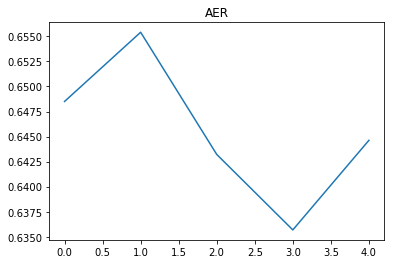

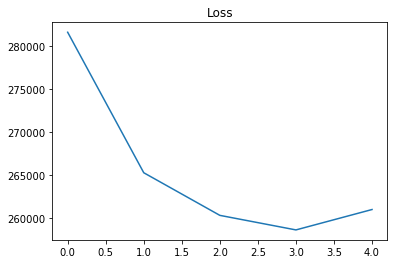

In [14]:
dev_e_path = '../../data/test/test.e.gz'
dev_f_path = '../../data/test/test.f.gz'
dev_wa = '../../data/test/test.wa.nonullalign'

tf.reset_default_graph()

with tf.Session() as sess:

  # some hyper-parameters
  # tweak them as you wish
#   batch_size=128  # on CPU, use something much smaller e.g. 1-16
  batch_size=4
  max_length=30
  lr = 0.001
  lr_decay = 0.0  # set to 0.0 when using Adam optimizer (default)
  emb_dim = 64
  mlp_dim = 128
  
  # our model
  model = NeuralIBM1Model(
    x_vocabulary=vocabulary_e, y_vocabulary=vocabulary_f, 
    batch_size=batch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, session=sess)
  
  # our trainer
  trainer = NeuralIBM1Trainer(
    model, train_e_path, train_f_path, 
    dev_e_path, dev_f_path, dev_wa,
    num_epochs=5, batch_size=batch_size, 
    max_length=max_length, lr=lr, lr_decay=lr_decay, session=sess)

  # now first TF needs to initialize all the variables
  print("Initializing variables..")
  sess.run(tf.global_variables_initializer())

  # now we can start training!
  print("Training started..")
  trainer.train()